In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [4]:
BASE_PATH = Path("..")
sys.path.append(str(BASE_PATH.resolve()))

In [5]:
from src.mobilenetv2.mobilenetv2 import MobileNetV2

In [6]:
tf.__version__

'2.5.0'

## CIFAR-10 Dataset

In [7]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [9]:
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [10]:
# train_images = resize(train_images, (len(train_images),224,224,3))
# test_images = resize(test_images, (len(test_images),224,224,3))

train_images = train_images / 255.
test_images = test_images / 255.

train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=len(CLASS_NAMES))
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=len(CLASS_NAMES))

In [11]:
train_images.shape

(50000, 32, 32, 3)

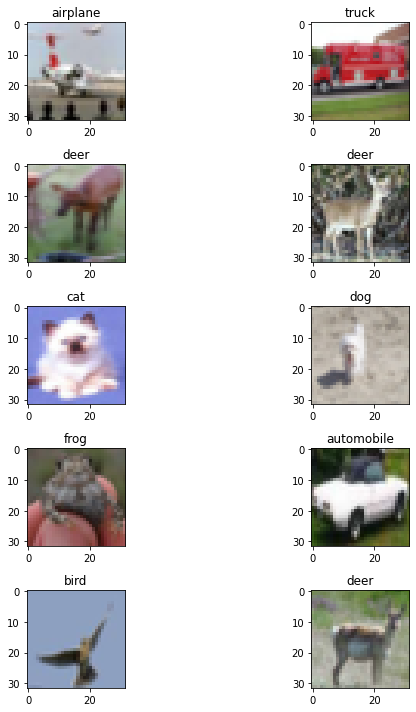

In [12]:
SAMPLE_SIZE = 10
samples = np.random.randint(0, len(train_images), size = SAMPLE_SIZE)

fig, axarr = plt.subplots(5, SAMPLE_SIZE//5, figsize = (10,10))
axs = axarr.ravel()

for idx, sample in enumerate(samples):
    axs[idx].imshow(train_images[sample,:,:,:])
    axs[idx].set_title(CLASS_NAMES[train_labels[sample,0]])
    
plt.tight_layout()

## Train MobilenetV2

In [13]:
ARTEFACT_DIR = Path('./artefacts/mobilenetv2')
if not ARTEFACT_DIR.exists():
    ARTEFACT_DIR.mkdir(parents=True, exist_ok=True)

In [14]:
mobilenetv2 = MobileNetV2(train_images.shape[1:], len(CLASS_NAMES), alpha=1.0)
model = mobilenetv2()

2021-10-25 03:09:41.738352: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=opt,
              loss=['categorical_crossentropy'],
              metrics=['accuracy'])

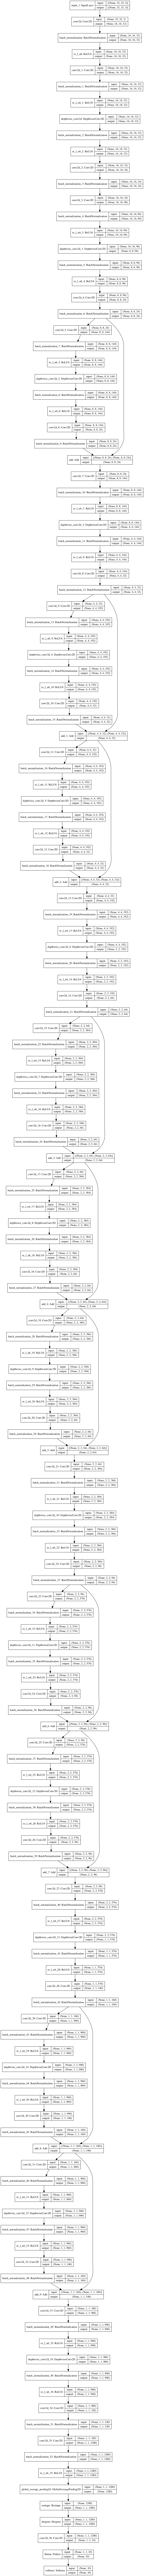

In [16]:
tf.keras.utils.plot_model(model, ARTEFACT_DIR / "mobilenetv2_info.png", show_shapes=True)


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_l_u6 (ReLU6)                 (None, 16, 16, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model.save(ARTEFACT_DIR / 'mobilenetv2.h5')

/Users/mikheilcircadia/opt/anaconda3/envs/py37-tf250/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
model.fit(x = train_images, y = train_labels_onehot, validation_split=0.20, verbose=1,epochs = 10)

2021-10-25 03:09:47.387473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1250/1250 [==============================] - 165s 126ms/step - loss: 2.2752 - accuracy: 0.1816 - val_loss: 1.9098 - val_accuracy: 0.2855
Epoch 2/10
1250/1250 [==============================] - 155s 124ms/step - loss: 1.8693 - accuracy: 0.3136 - val_loss: 1.7033 - val_accuracy: 0.3692
Epoch 3/10
1250/1250 [==============================] - 161s 129ms/step - loss: 1.7017 - accuracy: 0.3770 - val_loss: 1.6167 - val_accuracy: 0.4063
Epoch 4/10
1250/1250 [==============================] - 155s 124ms/step - loss: 1.5785 - accuracy: 0.4249 - val_loss: 1.7267 - val_accuracy: 0.4281
Epoch 5/10
1250/1250 [==============================] - 165s 132ms/step - loss: 1.4788 - accuracy: 0.4629 - val_loss: 1.4654 - val_accuracy: 0.4579
Epoch 6/10
1250/1250 [==============================] - 135s 108ms/step - loss: 1.3812 - accuracy: 0.5070 - val_loss: 1.4896 - val_accuracy: 0.4667
Epoch 7/10
1250/1250 [==============================] - 120s 96ms/step - loss: 1.2896 - accuracy: 0.5393 - val_l

## Evaluate MobilenetV2

In [20]:
test_loss, test_acc = model.evaluate(test_images,  test_labels_onehot, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 7s - loss: 1.3090 - accuracy: 0.5378

Test accuracy: 0.5378000140190125
